In [ ]:
# Assignment 2
# Senan Gaffori, 20949022
# Ayush Bhargava, 20889700

## Practice Questions

In [14]:
# Practice: Shipment Consolidation

# Step 0: import the libraries
# ----------------------------------------------------------------
import pandas as pd
from IPython.display import display
from docplex.mp.model import Model

# Step 1: import the dataframes
# ----------------------------------------------------------------
# Customer data
df_customers = pd.DataFrame({
    "Customer": [1, 2, 3],
    "Demand": [2, 3, 1],
    "ReleaseTime": [2, 3, 1],
    "DueDate": [6, 5, 4]})

# Route data
df_routes = pd.DataFrame({
    "RouteID": [1, 2],
    "Nodes": [["Factory", "C1", "C2"], ["Factory", "C2", "C3"]],
    "TravelTimes": [[1, 2], [1.5, 1]],   # segment-wise travel time
    "Cost": [6, 5]                       # fixed cost to operate
})

# Common carrier data
df_carrier = pd.DataFrame({
    "Customer": [1, 2, 3],
    "DeliveryTime": [1, 1, 1],
    "Cost": [8, 7, 9]})

# Travel time to customer on each route (k = customer, r = route)
tau_kr = {
    (1, 1): 1,    # C1 via R1
    (2, 1): 3,    # C2 via R1
    (2, 2): 1.5,  # C2 via R2
    (3, 2): 2.5}  # C3 via R2


# Which customers are on which routes
S_r = {
    1: [1, 2],   # Route 1 can serve C1, C2
    2: [2, 3]}   # Route 2 can serve C2, C3


display(df_customers)
display(df_routes)
display(df_carrier)

,Customer,Demand,ReleaseTime,DueDate
0,1,2,2,6
1,2,3,3,5
2,3,1,1,4


,RouteID,Nodes,TravelTimes,Cost
0,1,"[Factory, C1, C2]","[1, 2]",6
1,2,"[Factory, C2, C3]","[1.5, 1]",5


,Customer,DeliveryTime,Cost
0,1,1,8
1,2,1,7
2,3,1,9


In [ ]:
# Step 2: Define the model and decision variable x

# we define the list based on the slides
customers = [1, 2, 3] # customer index
routes = [1, 2] # two routes, r1 and r2
capacity = 4 # truck capacity

# How to calculate the time_periods
dispatch_times = []
for (k, r) in tau_kr: # Loop over each (customer k, route r) pair that has a travel time
    
    due_date = df_customers.loc[k - 1, "DueDate"] # Get due date of customer k
    travel_time = tau_kr[(k, r)] # Get travel time to customer k via route r
    # -----------------
    latest_time = due_date - travel_time # Compute the latest time the truck can leave to serve this customer (t ≤ dk−τkr)
    # -----------------
    dispatch_times.append(latest_time)  # Add to the list

latest_dispatch_time = max(dispatch_times) # Take the maximum of all valid dispatch times
time_periods = list(range(1, int(latest_dispatch_time) + 1)) # Based on the maximum of dispatch time, create the time period list (e.g., [1, 2, 3,...])
print(time_periods)

mdl = Model("CPLEX_Shipment_Consolidation")

x = mdl.binary_var_dict(((k, r, t) for k in customers for r in routes for t in time_periods), name = "x")
y = mdl.binary_var_dict(((r, t) for r in routes for t in time_periods), name = "y")
z = mdl.binary_var_dict(customers, name = "z")

[1, 2, 3, 4, 5]


In [ ]:
# Step 3: Define the constraints
# 3-1. Capacity constraint per route and time
for r in routes:
    for t in time_periods:
        mdl.add_constraint(sum( df_customers.loc[k-1, "Demand"] * x[k, r, t] for k in S_r[r]
                               if df_customers.loc[k-1, "ReleaseTime"] <= t <= df_customers.loc[k-1, "DueDate"] - tau_kr[(k, r)]) 
                               <= capacity * y[r, t])

# 3-2. Each customer is served exactly once (truck or carrier)
for k in customers:
    mdl.add_constraint(mdl.sum(x[k, r, t]
                               for r in routes if k in S_r[r]
                               for t in time_periods
                               if df_customers.loc[k-1, "ReleaseTime"] <= t <= df_customers.loc[k-1, "DueDate"] - tau_kr[(k, r)]) 
                               + z[k] == 1)  
# 3-3. optional constraints


# Step 4: Objective – minimize the cost
mdl.minimize(mdl.sum(df_routes.loc[r - 1, "Cost"] * x[k, r, t] for k in customers for r in routes for t in time_periods)
             + mdl.sum(df_carrier.loc[k - 1, "Cost"] * z[k] for k in customers))

# Step 5: Solve and print
solution = mdl.solve(log_output = True)

# --- Output solution ---
if solution:
    print("Objective value:", solution.objective_value)

    print("Truck Assignments (x_krt):")
    for k, r, t in x:
        if x[k, r, t].solution_value > 0.5:
            print(f"Customer {k} is served by Route {r} at time {t}; x[{k}, {r}, {t}] = 1")

    print("Route Dispatches (y_rt):")
    for r, t in y:
        if y[r, t].solution_value > 0.5:
            print(f"Route {r} is dispatched at time {t}; y[{r}, {t}] = 1")

    print("Customers served by the carrier (z_k):")
    for k in z:
        if z[k].solution_value > 0.5:
            print(f"Customer {k} is served via common carrier")
else:
    print("No feasible solution found.")

# Optional: Show the model formulation
print("\nMODEL FORMULATION:")
print(mdl.export_as_lp_string())

Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
2 of 2 MIP starts provided solutions.
MIP start 'm1' defined initial solution with objective 16.0000.
Tried aggregator 1 time.
MIP Presolve eliminated 26 rows and 43 columns.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.02 ticks)

Root node processing (before b&c):
  Real time             =    0.00 sec. (0.03 ticks)
Parallel b&c, 24 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.00 sec. (0.03 ticks)
Objective value: 16.0
Truck Assignments (x_krt):
Customer 1 is served by Route 1 at time 2; x[1, 1, 2] = 1
Customer 2 is served by Route 2 at time 3; x[2, 2, 3] = 1
Customer 3 is served by Route 2 at time 1; x[3, 2, 1] = 1
Route Dispatches (y_rt):
Route 1 is dispatched at time 2; y[1, 2] = 1
Route 1 is dispatche

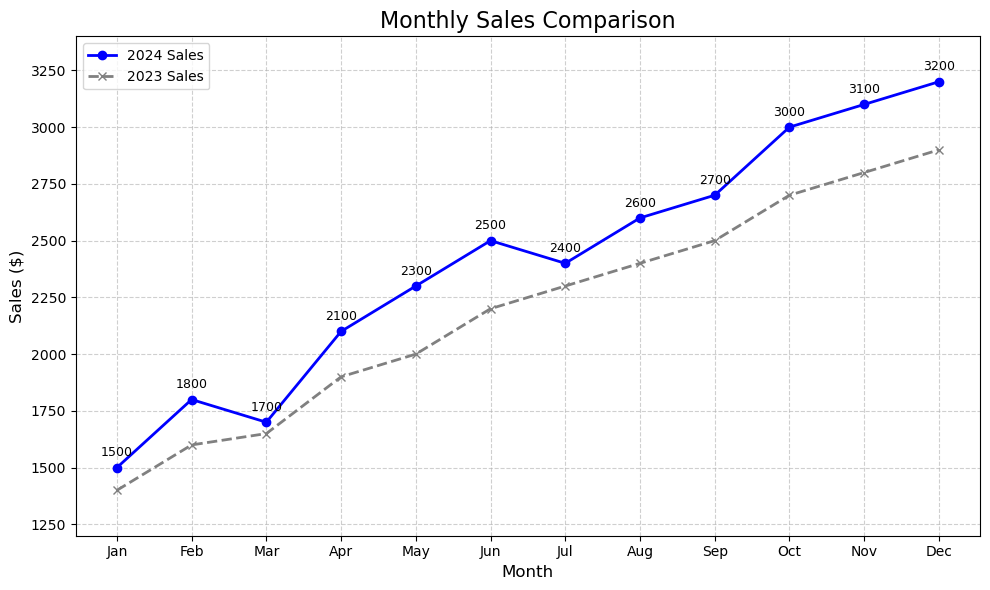

In [1]:
import matplotlib.pyplot as plt

# Monthly labels for X-axis
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Actual sales data (e.g., this year vs last year)
sales = [1500, 1800, 1700, 2100, 2300, 2500, 2400, 2600, 2700, 3000, 3100, 3200]
sales_last_year = [1400, 1600, 1650, 1900, 2000, 2200, 2300, 2400, 2500, 2700, 2800, 2900]

# Step 0: Create a figure with specified size
plt.figure(figsize = (10, 6))

# Step 1: Plot the lines
plt.plot(months, sales, label = '2024 Sales', color = 'blue', marker = 'o', linestyle = '-', linewidth = 2)
plt.plot(months, sales_last_year, label = '2023 Sales', color = 'gray', marker = 'x', linestyle = '--', linewidth = 2)

# Step 2: Add plot title and axis labels and other options
plt.title("Monthly Sales Comparison", fontsize = 16)
plt.xlabel("Month", fontsize = 12)
plt.ylabel("Sales ($)", fontsize = 12)
plt.grid(True, linestyle = '--', alpha = 0.6) # Optional: Add grid for better readability
plt.legend(loc='upper left') # Optional: Add a legend in the upper left corner

# Optional: Add value annotations to the 2024 line
for i, value in enumerate(sales):
    plt.text(i, value + 50, str(value), ha = 'center', fontsize = 9)

plt.ylim(1200, 3400) # Adjust y-axis limit for better layout
plt.tight_layout() # optional: Make layout tight to avoid clipping

# Step 3: Show the final plot
plt.show()

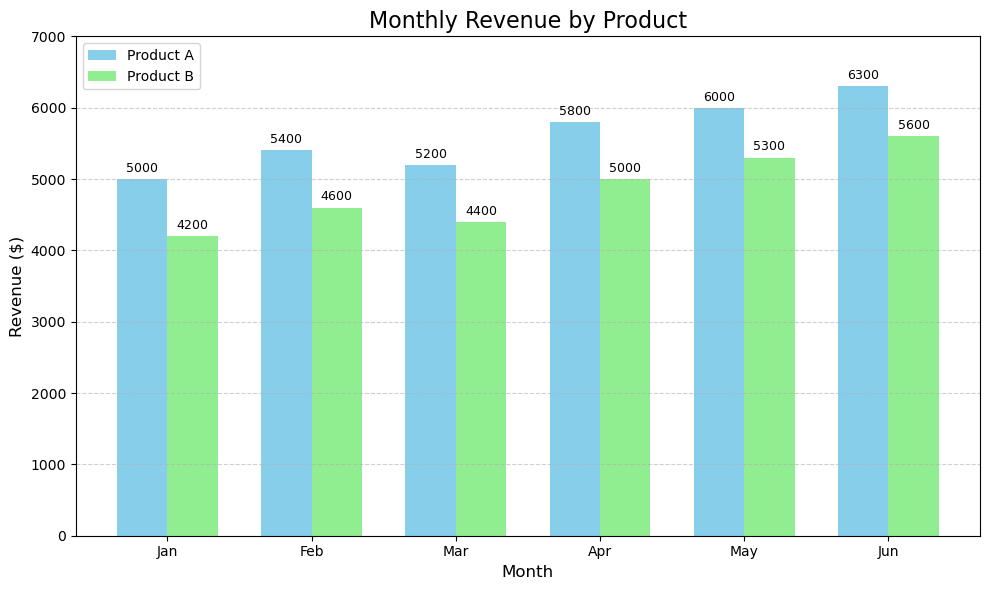

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Monthly labels for X-axis (first 6 months)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']

# Revenue from two product categories
revenue_A = [5000, 5400, 5200, 5800, 6000, 6300]
revenue_B = [4200, 4600, 4400, 5000, 5300, 5600]

# Step 0: Create a figure with specified size
plt.figure(figsize = (10, 6))

# Step 1: Plot the grouped bar chart
bar_width = 0.35
x = np.arange(len(months))  # numeric x positions for each month

# Plot bars for each category
plt.bar(x - bar_width/2, revenue_A, width = bar_width, label = 'Product A', color = 'skyblue')
plt.bar(x + bar_width/2, revenue_B, width = bar_width, label = 'Product B', color = 'lightgreen')

# Step 2: Add plot title and axis labels and other options
plt.title("Monthly Revenue by Product", fontsize = 16)
plt.xlabel("Month", fontsize = 12)
plt.ylabel("Revenue ($)", fontsize = 12)
plt.xticks(x, months)  # Set x-axis tick labels to month names
plt.grid(axis = 'y', linestyle = '--', alpha = 0.6)  # Optional: Add horizontal gridlines
plt.legend(loc = 'upper left')  # Optional: Add a legend

# Optional: Add value annotations on top of bars
for i in range(len(x)):
    plt.text(x[i] - bar_width/2, revenue_A[i] + 100, str(revenue_A[i]), ha = 'center', fontsize = 9)
    plt.text(x[i] + bar_width/2, revenue_B[i] + 100, str(revenue_B[i]), ha = 'center', fontsize = 9)

plt.ylim(0, 7000)  # Adjust y-axis limit
plt.tight_layout()  # optional: Make layout tight to avoid clipping

# Step 3: Show the final plot
plt.show()

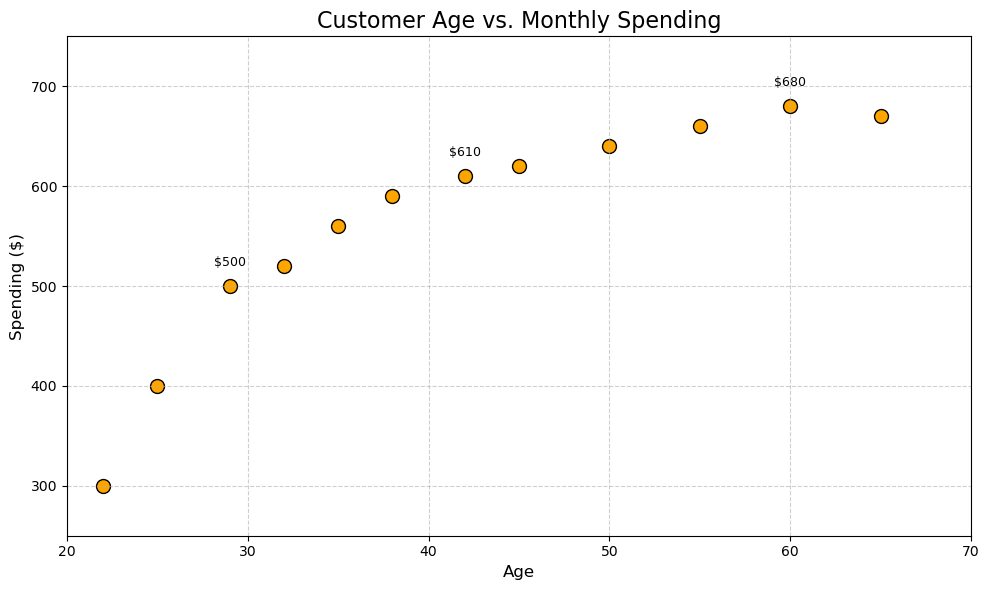

In [3]:
import matplotlib.pyplot as plt

# Step 0: Prepare data
# X: Age of customers
# Y: Monthly spending in dollars
ages = [22, 25, 29, 32, 35, 38, 42, 45, 50, 55, 60, 65]
spending = [300, 400, 500, 520, 560, 590, 610, 620, 640, 660, 680, 670]

# Step 1: Create a figure with specified size
plt.figure(figsize=(10, 6))

# Step 2: Plot the scatter points
plt.scatter(ages, spending, color = 'orange', edgecolor = 'black', s = 100)

# Step 3: Add plot title and axis labels and other options
plt.title("Customer Age vs. Monthly Spending", fontsize = 16)
plt.xlabel("Age", fontsize = 12)
plt.ylabel("Spending ($)", fontsize = 12)
plt.grid(True, linestyle = '--', alpha = 0.6)  # Optional: Add grid for better readability

# Optional: Add annotations for some points
highlight = [2, 6, 10]  # selected points to annotate
for i in highlight:
    plt.text(ages[i], spending[i] + 20, f"${spending[i]}", ha = 'center', fontsize = 9)

plt.xlim(20, 70)  # Set x-axis range (age)
plt.ylim(250, 750)  # Set y-axis range (spending)
plt.tight_layout()  # optional: Make layout tight to avoid clipping

# Step 4: Show the final plot
plt.show()

[92.64052346 79.00157208 84.78737984 97.40893199 93.6755799  65.2272212
 84.50088418 73.48642792 73.96781148 79.10598502 76.44043571 89.54273507
 82.61037725 76.21675016 79.43863233 78.33674327 89.94079073 72.94841736
 78.13067702 66.45904261 49.47010184 81.53618595 83.64436199 67.5783498
 97.69754624 60.45634325 75.45758517 73.1281615  90.32779214 89.6935877
 76.54947426 78.7816252  66.12214252 55.19203532 71.52087851 76.56348969
 87.30290681 87.02379849 71.12673183 71.97697249 64.51447035 60.79982063
 57.93729809 94.50775395 69.90347818 70.61925698 62.4720464  82.77490356
 58.86102152 72.8725972  66.04533439 78.86902498 69.89194862 63.19367816
 74.71817772 79.28331871 75.66517222 78.02471898 68.65677906 71.37258834
 68.27539552 71.40446838 66.86853718 57.73717398 76.77426142 70.98219064
 58.69801653 79.62782256 65.92701636 75.51945396 82.29090562 76.28982911
 86.39400685 62.6517418  79.02341641 68.15189909 66.29202851 69.21150335
 71.88447468 75.56165342 63.34850159 84.00826487 79.65

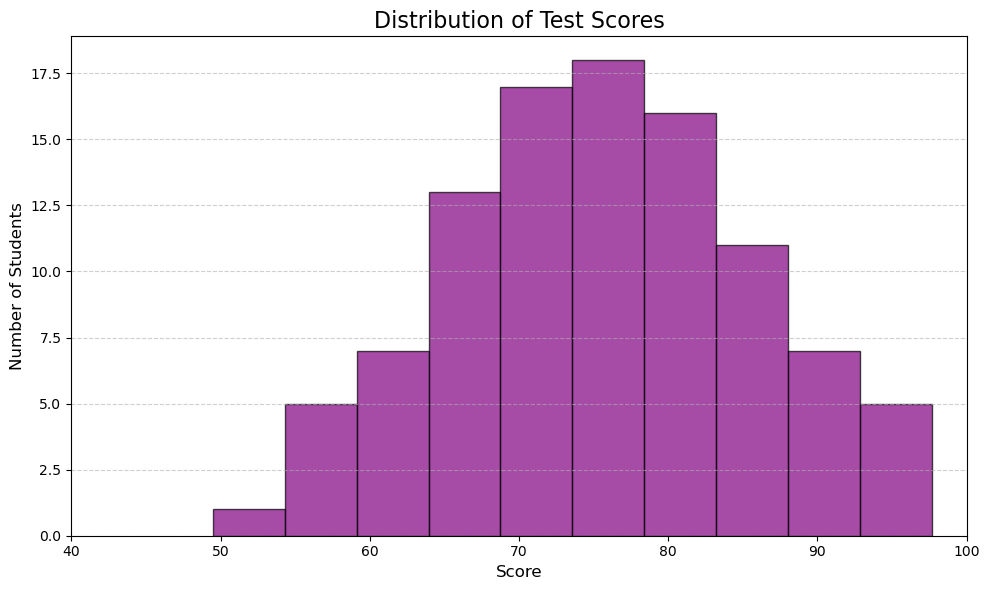

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Step 0: Generate or prepare data
# Simulated test scores (normal distribution)
np.random.seed(0)
scores = np.random.normal(loc = 75, scale = 10, size = 100)  # mean=75, std=10, 100 students
print(scores)

# Step 1: Create a figure with specified size
plt.figure(figsize=(10, 6))

# Step 2: Plot the histogram
plt.hist(scores, bins = 10, color ='purple', edgecolor = 'black', alpha = 0.7)

# Step 3: Add plot title and axis labels and other options
plt.title("Distribution of Test Scores", fontsize = 16)
plt.xlabel("Score", fontsize = 12)
plt.ylabel("Number of Students", fontsize = 12)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.6)  # Optional: Add horizontal grid lines

plt.xlim(40, 100)  # Optional: Set score range
plt.tight_layout()  # optional: Make layout tight to avoid clipping

# Step 4: Show the final plot
plt.show()

*Assignment 4 Analysis - Simulation and Visualizations*
 *Limit to only 1 order per customer due to computational constraints*

In [17]:
import pandas as pd
from docplex.mp.model import Model
from datetime import timedelta

# --- Step 1: Load and preprocess data ---
file_path = "/Users/senan/Downloads/MS434_Lab4_Assignment_Data.xlsx"

# Load data
order_df = pd.read_excel(file_path, sheet_name="Order record")
info_df = pd.read_excel(file_path, sheet_name="Other information", header=None)

# Clean up
order_df["ship_to"] = order_df["ship_to"].astype(str).str.zfill(10)
order_df["req_dt"] = pd.to_datetime(order_df["req_dt"], format="%Y%m%d")
order_df["ReleaseTime"] = order_df["req_dt"] - timedelta(days=4)
order_df["DueDate"] = order_df["req_dt"] + timedelta(days=4)

# Convert to days-from-base
base_date = order_df["ReleaseTime"].min()
order_df["release_day"] = (order_df["ReleaseTime"] - base_date).dt.days
order_df["due_day"] = (order_df["DueDate"] - base_date).dt.days

# Limit to only 1 order per customer due to computational constraints
order_df = order_df.groupby("ship_to").head(1).copy()
orders = order_df.index.tolist()

# Time periods
time_periods = list(range(order_df["release_day"].min(), order_df["due_day"].max() + 1))

# Container info
container_cost = {'20ft': float(info_df.iloc[0, 2]), '40ft': float(info_df.iloc[1, 2])}
container_capacity = {'20ft': float(info_df.iloc[2, 2]), '40ft': float(info_df.iloc[3, 2])}
container_types = ['20ft', '40ft']

# --- Step 2: Define DOcplex model ---
mdl = Model(name="Docplex_Shipment_Consolidation")

# Decision variables
x = mdl.binary_var_dict(((o, t, c) for o in orders for t in time_periods for c in container_types), name="x")
y = mdl.binary_var_dict(((t, c) for t in time_periods for c in container_types), name="y")

# --- Step 3: Constraints ---

# 1. Each order is served exactly once
for o in orders:
    release = order_df.loc[o, "release_day"]
    due = order_df.loc[o, "due_day"]
    mdl.add_constraint(
        mdl.sum(x[o, t, c] for t in time_periods for c in container_types if release <= t <= due) == 1,
        f"Serve_Order_{o}"
    )

# 2. Container capacity constraint at each time
for t in time_periods:
    for c in container_types:
        mdl.add_constraint(
            mdl.sum(order_df.loc[o, "Qty"] * x[o, t, c] for o in orders
                    if order_df.loc[o, "release_day"] <= t <= order_df.loc[o, "due_day"])
            <= container_capacity[c] * y[t, c],
            f"Capacity_{t}_{c}"
        )

# --- Step 4: Objective Function ---
mdl.minimize(
    mdl.sum(container_cost[c] * y[t, c] for t in time_periods for c in container_types)
)

# --- Step 5: Solve ---
solution = mdl.solve(log_output=True)

# --- Step 6: Output Results ---
if solution:
    print(f"\nObjective Value: ${solution.objective_value:,.2f}")

    print("\nDispatches:")
    for (t, c) in y:
        if y[t, c].solution_value > 0.5:
            print(f"→ Dispatch {c} container at time {t}")

    print("\nOrder Assignments:")
    for (o, t, c) in x:
        if x[o, t, c].solution_value > 0.5:
            cust = order_df.loc[o, "ship_to"]
            qty = order_df.loc[o, "Qty"]
            print(f"→ Order {o} (Cust {cust}, Qty {qty}) in {c} container at time {t}")
else:
    print("No feasible solution found.")


Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve eliminated 133 rows and 750 columns.
MIP Presolve modified 81 coefficients.
Aggregator did 18 substitutions.
Reduced MIP has 21 rows, 72 columns, and 126 nonzeros.
Reduced MIP has 72 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.48 ticks)
Found incumbent of value 19000.000000 after 0.01 sec. (0.56 ticks)
Probing time = 0.00 sec. (0.08 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 21 rows, 72 columns, and 126 nonzeros.
Reduced MIP has 72 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.16 ticks)
Probing time = 0.00 sec. (0.08 ticks)
Clique table members: 48.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.00 sec. (0.07 ticks)

        Nodes

/var/folders/5s/mp_77npd59q9hkcgz686gjs40000gn/T/ipykernel_13502/4217651125.py:53: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
/Users/senan/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


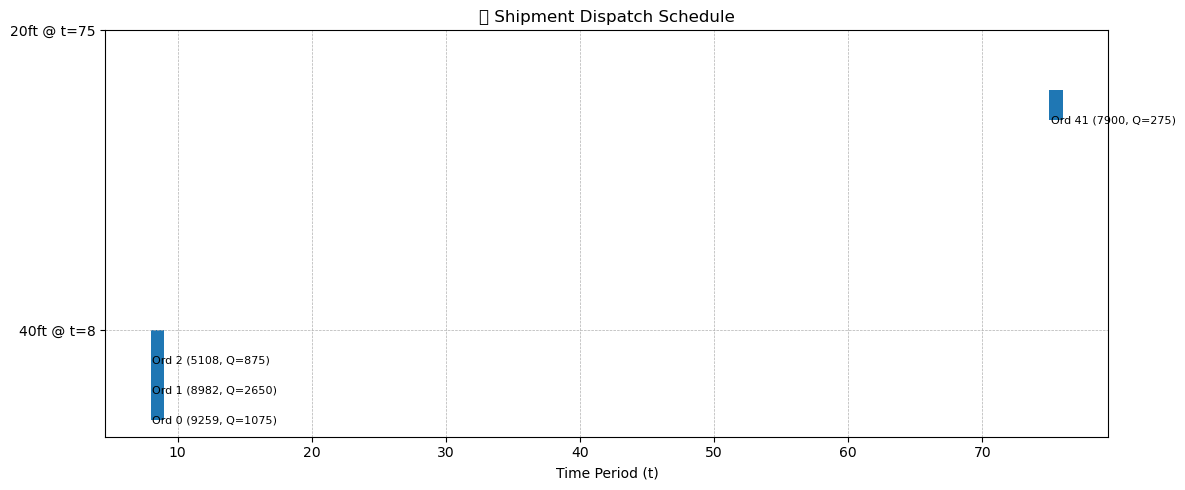

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Collect visualization data
dispatch_data = []
dispatch_id = 0

for (t, c) in y:
    if y[t, c].solution_value > 0.5:
        # For each dispatch, collect the orders assigned to it
        dispatch_orders = [(o, order_df.loc[o, "ship_to"], order_df.loc[o, "Qty"])
                           for o in orders if x[o, t, c].solution_value > 0.5]
        if dispatch_orders:
            dispatch_data.append({
                "dispatch_id": dispatch_id,
                "container_type": c,
                "time": t,
                "orders": dispatch_orders
            })
            dispatch_id += 1

# Plotting
fig, ax = plt.subplots(figsize=(12, 5))

yticks = []
ytick_labels = []

for i, dispatch in enumerate(dispatch_data):
    y_pos = i
    yticks.append(y_pos)
    ytick_labels.append(f"{dispatch['container_type']} @ t={dispatch['time']}")

    start_x = dispatch["time"]
    bar_width = 1  # fixed width for each dispatch bar
    height = 0.8

    # Color by customer
    for j, (o, cust, qty) in enumerate(dispatch["orders"]):
        ax.broken_barh([(start_x, bar_width)],
                       (y_pos - 0.3 + 0.1 * j, 0.1),
                       facecolors='tab:blue')
        ax.text(start_x + 0.1,
                y_pos - 0.3 + 0.1 * j,
                f"Ord {o} ({cust[-4:]}, Q={qty})",
                va='center', fontsize=8, color='black')

# Styling
ax.set_xlabel("Time Period (t)")
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)
ax.set_title("Shipment Dispatch Schedule")
ax.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


/var/folders/5s/mp_77npd59q9hkcgz686gjs40000gn/T/ipykernel_13502/3688462546.py:42: UserWarning: Glyph 128666 (\N{DELIVERY TRUCK}) missing from current font.
  plt.tight_layout()
/Users/senan/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128666 (\N{DELIVERY TRUCK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


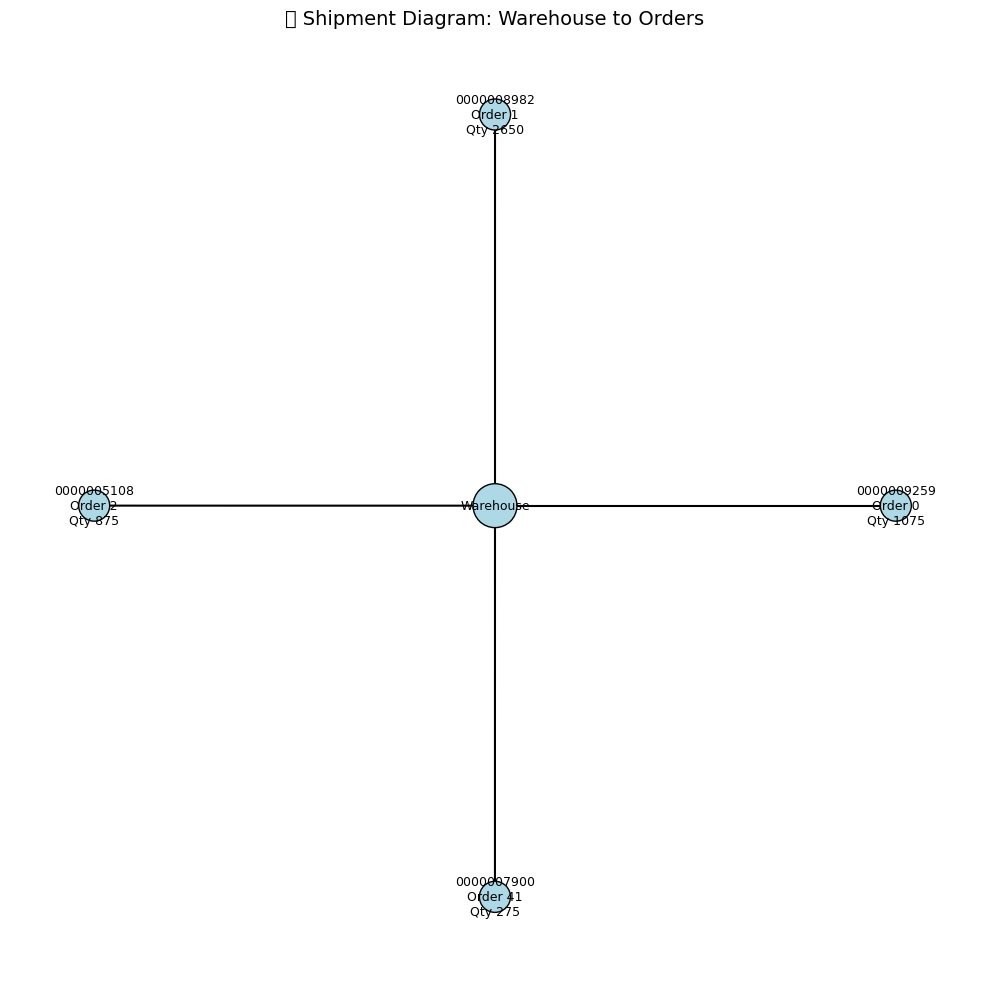

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Collect unique customer IDs from assigned orders
assigned_orders = [
    (o, order_df.loc[o, "ship_to"], order_df.loc[o, "Qty"])
    for (o, t, c) in x
    if x[o, t, c].solution_value > 0.5
]

# Create graph
G = nx.DiGraph()

# Add warehouse node
G.add_node("Warehouse", pos=(0, 0), size=1000)

# Add customer nodes spaced in a circle
angle_step = 360 / len(assigned_orders)
radius = 5
positions = {"Warehouse": (0, 0)}
for i, (o, cust_id, qty) in enumerate(assigned_orders):
    angle_rad = i * angle_step * 3.1415 / 180
    x = radius * np.cos(angle_rad)
    y = radius * np.sin(angle_rad)
    node_label = f"{cust_id}\nOrder {o}\nQty {qty}"
    G.add_node(node_label, pos=(x, y), size=500)
    G.add_edge("Warehouse", node_label)

# Get positions and sizes
pos = nx.get_node_attributes(G, "pos")
sizes = [G.nodes[n].get("size", 300) for n in G.nodes]

# Draw
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color='lightblue', edgecolors='black')
nx.draw_networkx_labels(G, pos, font_size=9, font_color='black')
nx.draw_networkx_edges(G, pos, arrows=False, width=1.5)

plt.title("Shipment Diagram: Warehouse to Orders", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()


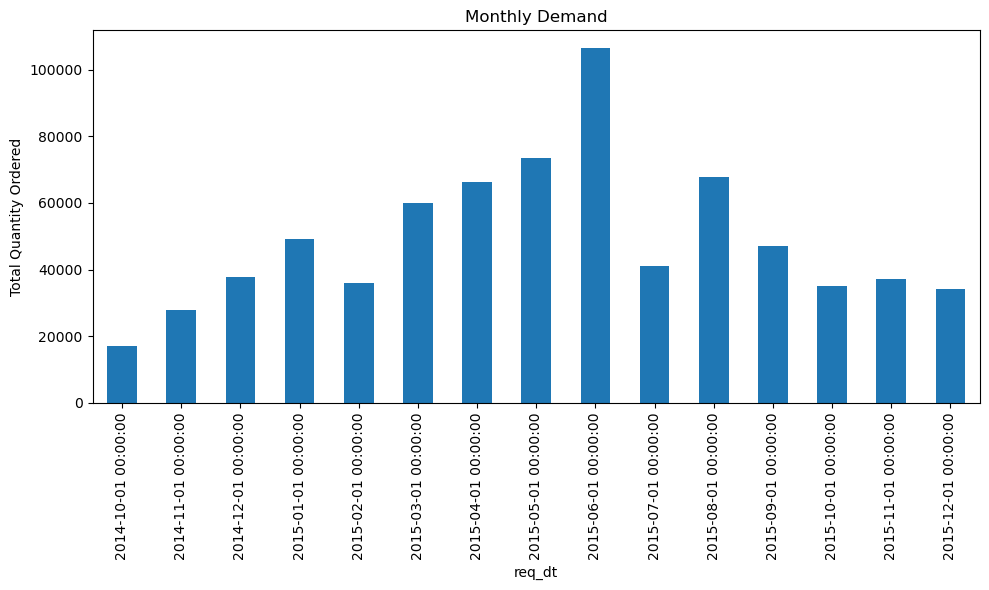

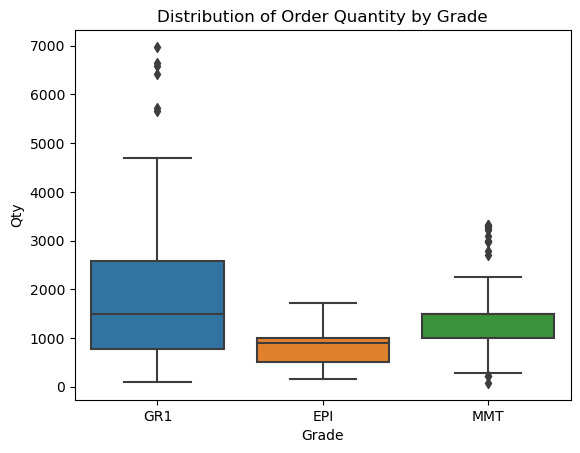

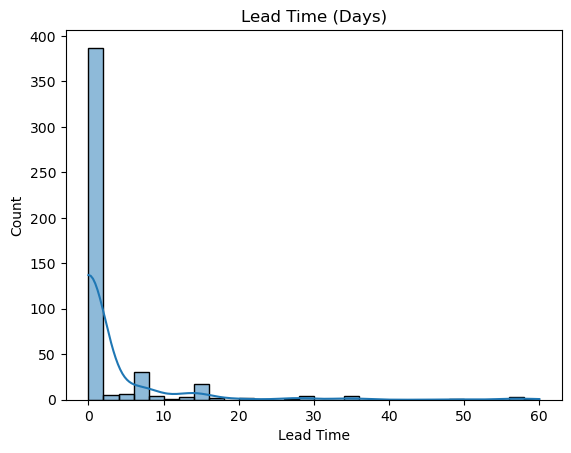

Percentage of orders on or before request date: 81.95%


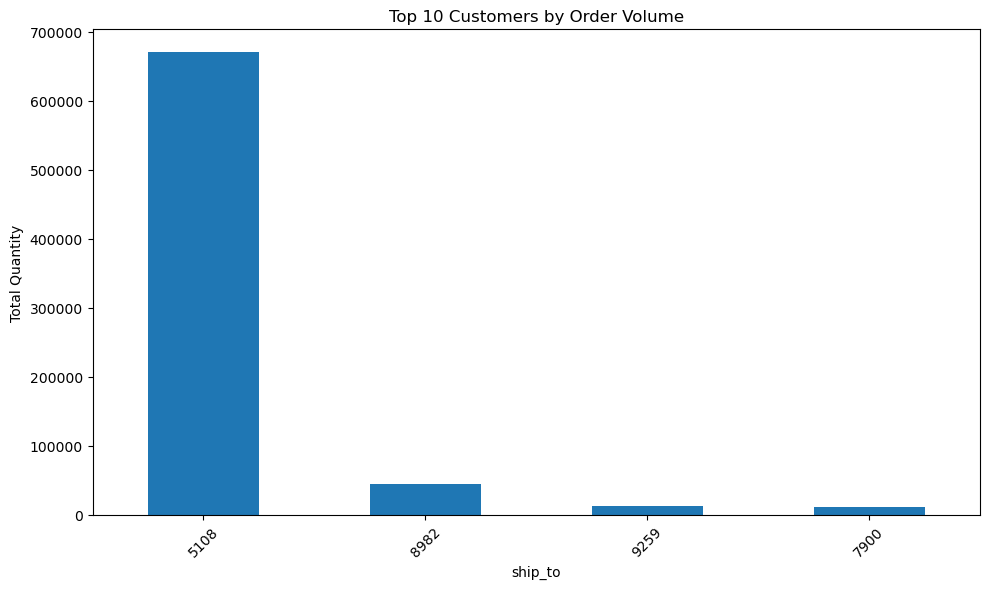

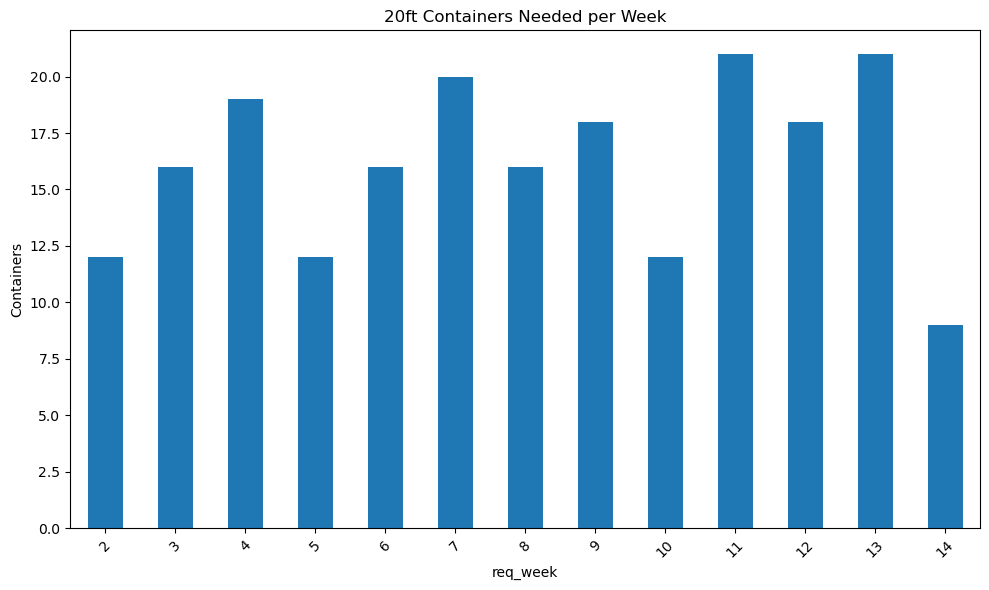

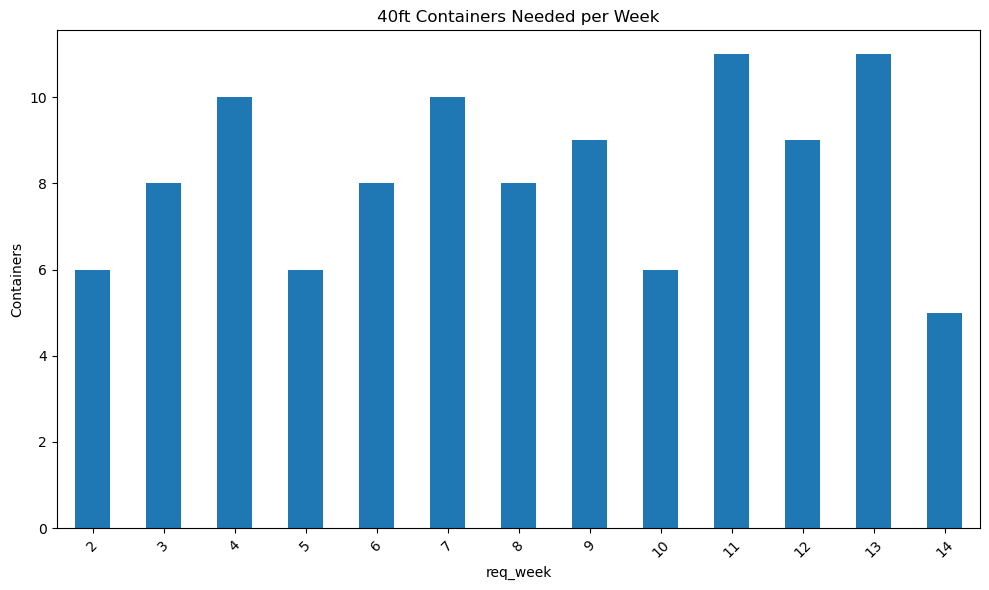

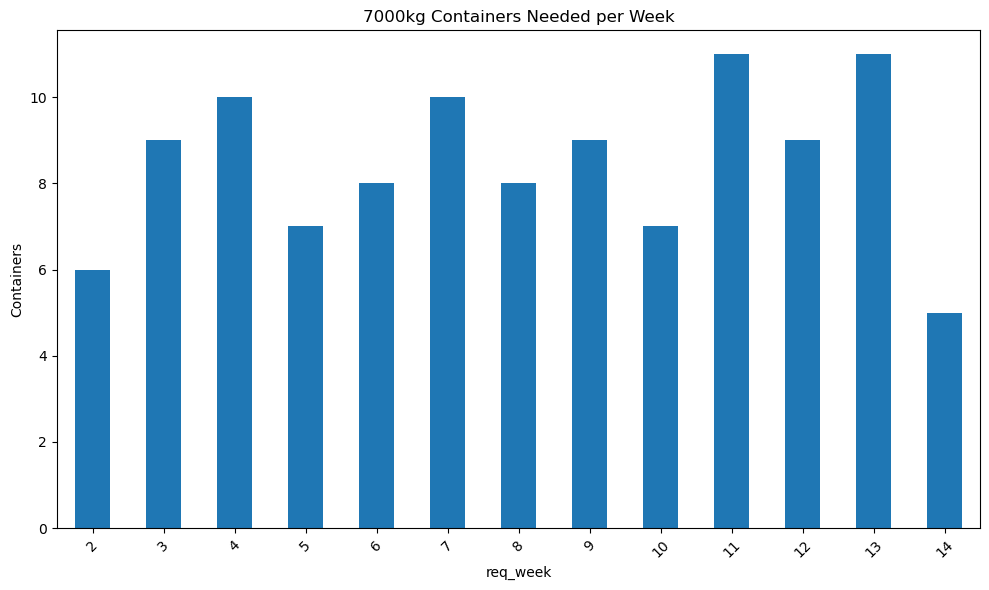

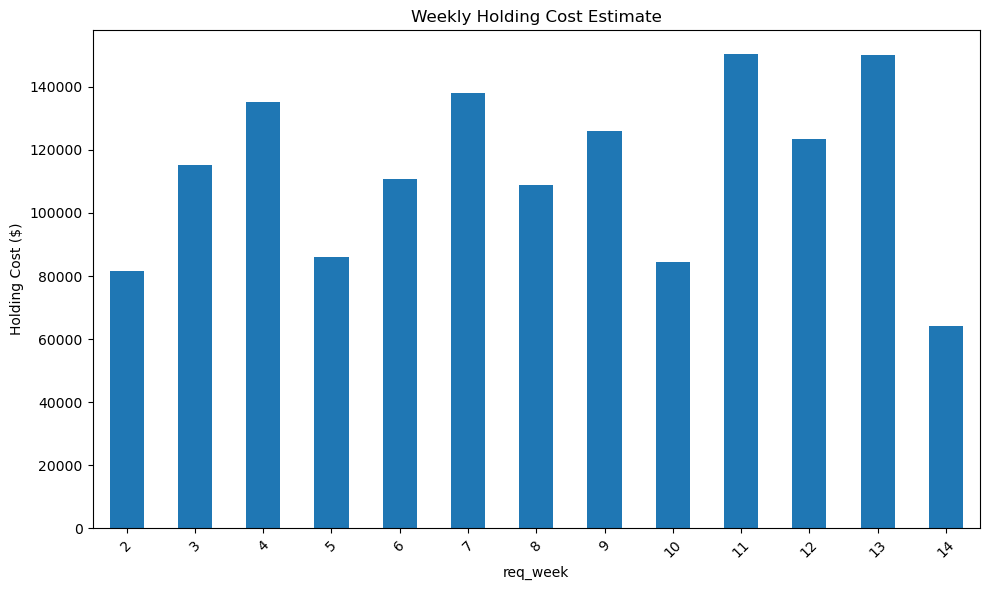

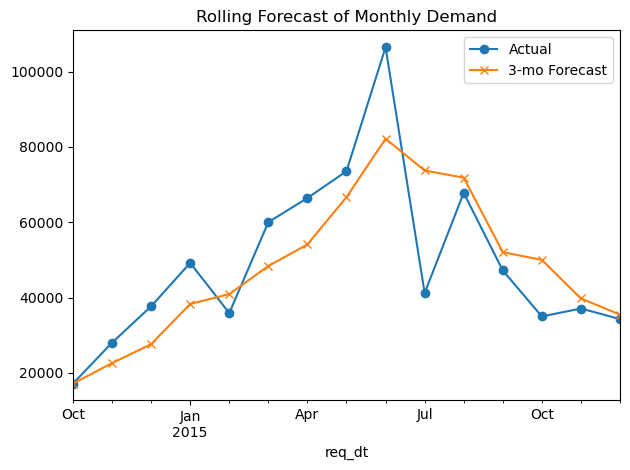

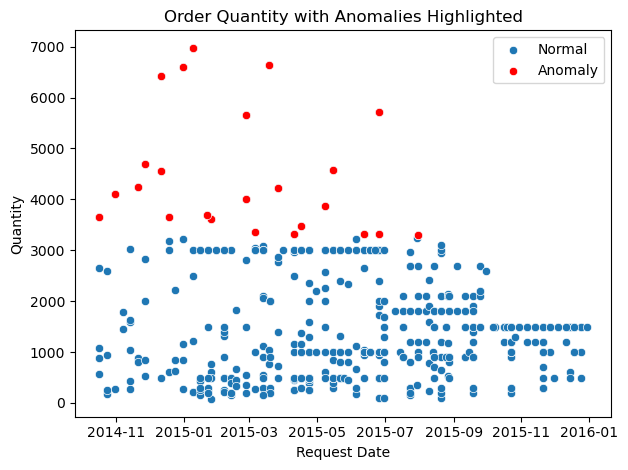

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === Updated file path ===
file_path = "/Users/senan/Downloads/MS434_Lab4_Assignment_Data.xlsx"

# Load the Excel file
xls = pd.ExcelFile(file_path)

# Load sheets
order_df = xls.parse('Order record')
info_df = xls.parse('Other information')

# Convert date columns
order_df['req_dt'] = pd.to_datetime(order_df['req_dt'], format='%Y%m%d')
order_df['curr_dt'] = pd.to_datetime(order_df['curr_dt'], format='%Y%m%d')

# Lead time
order_df['lead_time_days'] = (order_df['curr_dt'] - order_df['req_dt']).dt.days

# ========== Demand Analysis ==========
monthly_demand = order_df.groupby(order_df['req_dt'].dt.to_period('M'))['Qty'].sum().to_timestamp()
monthly_demand.plot(kind='bar', figsize=(10, 6), title='Monthly Demand')
plt.ylabel('Total Quantity Ordered')
plt.tight_layout()
plt.show()

sns.boxplot(x='Grade', y='Qty', data=order_df)
plt.title('Distribution of Order Quantity by Grade')
plt.show()

# ========== Timeliness ==========
sns.histplot(order_df['lead_time_days'], bins=30, kde=True)
plt.title('Lead Time (Days)')
plt.xlabel('Lead Time')
plt.show()

on_time = (order_df['lead_time_days'] <= 0).mean() * 100
print(f"Percentage of orders on or before request date: {on_time:.2f}%")

# ========== Top Customers ==========
top_customers = order_df.groupby('ship_to')['Qty'].sum().nlargest(10)
top_customers.plot(kind='bar', figsize=(10, 6), title='Top 10 Customers by Order Volume')
plt.ylabel('Total Quantity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ========== Container Optimization ==========
container_capacities = {'20ft': 3600, '40ft': 7200, '7000kg': 7000}
weekly_qty = order_df.groupby('req_week')['Qty'].sum()

for size, capacity in container_capacities.items():
    needs = (weekly_qty / capacity).apply(np.ceil)
    needs.plot(kind='bar', figsize=(10, 6), title=f'{size} Containers Needed per Week')
    plt.ylabel('Containers')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ========== Holding Cost ==========
holding_cost_per_unit_per_week = 2
weekly_holding_cost = weekly_qty * holding_cost_per_unit_per_week
weekly_holding_cost.plot(kind='bar', figsize=(10, 6), title='Weekly Holding Cost Estimate')
plt.ylabel('Holding Cost ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ========== Rolling Forecast ==========
rolling_forecast = monthly_demand.rolling(3, min_periods=1).mean()
monthly_demand.plot(marker='o', label='Actual')
rolling_forecast.plot(marker='x', label='3-mo Forecast')
plt.legend()
plt.title('Rolling Forecast of Monthly Demand')
plt.tight_layout()
plt.show()

# ========== Anomaly Detection ==========
threshold = order_df['Qty'].quantile(0.95)
anomalies = order_df[order_df['Qty'] > threshold]
sns.scatterplot(data=order_df, x='req_dt', y='Qty', label='Normal')
sns.scatterplot(data=anomalies, x='req_dt', y='Qty', color='red', label='Anomaly')
plt.title('Order Quantity with Anomalies Highlighted')
plt.xlabel('Request Date')
plt.ylabel('Quantity')
plt.legend()
plt.tight_layout()
plt.show()


**Written Description of Analysis and Visualizations**

In this lab, we used statistical demand analysis and an optimization model to reduce shipment costs. Our Docplex model utilized one order per customer to speed up computation while using delivery windows and container capacities. 

We used two representations in our analysis: a network graph to show the links from warehouse to customer, and a Gantt chart to show container movement schedules. In the output of the optimization results, we had three orders go into one 40ft container (t=8), and one smaller order used a 20ft container (t=75) at minimum cost.

Statistically, we found that 82% of orders were on time and high volume customers dominated weekly demand—making consolidation well warranted.